# Final Project: ASL Recognition
### Professor: Weizhe Li
### Student: Levan Sulimanov

# Model Evaluation Code:

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Defining Dataloaders:

In [17]:
###################################### CREDITS ######################################
# https://learnopencv.com/human-action-recognition-using-detectron2-and-lstm/
#####################################################################################

import numpy as np
import torch.optim as optim
import torchmetrics
import pytorch_lightning as pl

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import time
from numpy import genfromtxt

class PoseDataset(Dataset):
    def __init__(self, data_arr):
        self.data_arr = data_arr

    def __len__(self):
        return len(self.data_arr)

    def __getitem__(self, idx):
        X_path = self.data_arr[idx][0]
        y = self.data_arr[idx][1]
        
        X = torch.from_numpy(genfromtxt(X_path, delimiter=',')).float()
        
        return X, y
    
    
def load_X_and_Y(data_path, train_mode="train"):
        
        data_x_y_arr = []
        
        read_from_dir = os.path.join(data_path, train_mode)
        
        # go over each class folder, get subsamples per class, and return tuples [sample_path, class_number]
        for class_folder in os.listdir(read_from_dir):
            class_abs_path = os.path.join(read_from_dir, class_folder)
            for sample in os.listdir(class_abs_path):
                sample_path = os.path.join(class_abs_path, sample)
                class_num = class_to_label_num[class_folder]
                data_x_y_arr.append([sample_path, class_num])

        # print(f"Collected full list for {train_mode}:\n{data_x_y_arr}")
        return data_x_y_arr


class PoseDataModule():
    def __init__(self, data_root, batch_size=32):
        super().__init__()

        self.data_root = data_root
        self.batch_size = batch_size
        
        train_data_arr = load_X_and_Y(self.data_root, train_mode="train")
        eval_data_arr = load_X_and_Y(self.data_root, train_mode="val")
        test_data_arr = load_X_and_Y(self.data_root, train_mode="test")
        self.train_dataset = PoseDataset(train_data_arr)
        self.val_dataset = PoseDataset(eval_data_arr)
        self.test_dataset = PoseDataset(test_data_arr)

    def train_dataloader(self):
        # train loader
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )
        return train_loader

    def val_dataloader(self):
        # validation loader
        val_loader = torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0
        )
        return val_loader
    
    def test_dataloader(self):
        # validation loader
        test_loader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0
        )
        return test_loader
    

# We have 6 output action classes.
TOT_ACTION_CLASSES = 9 #6

#lstm classifier definition
class ActionClassificationLSTM(pl.LightningModule):
    # initialise method
    def __init__(self, input_features, hidden_dim, learning_rate=0.001):
        super().__init__()
        # save hyperparameters
        self.save_hyperparameters()
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_features, hidden_dim, batch_first=True)
        # The linear layer that maps from hidden state space to classes
        self.linear = nn.Linear(hidden_dim, TOT_ACTION_CLASSES)

    def forward(self, x):
        # invoke lstm layer
        lstm_out, (ht, ct) = self.lstm(x)
        # invoke linear layer
        return self.linear(ht[-1])

In [36]:
#####################################################################################################################################
## Credits: https://yeseullee0311.medium.com/pytorch-performance-evaluation-of-a-classification-model-confusion-matrix-fbec6f4e8d0 ##
#####################################################################################################################################

# function to collect Model's Accuracy, Precision, Recall, F1-Score, Confusion Matrix, and NPV
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
def test_model(model,test_dataloader):  # ,device):
    CM=0
    model.eval()
    with torch.no_grad():
        for data in test_dataloader:
            keypoints, labels = data[0], data[1]
            #print(keypoints)
            #print(labels)
            #keypoints = keypoints  # .to(device)
            #labels = labels  # .to(device)
            
            outputs = model(keypoints) #file_name
            preds = torch.argmax(outputs.data, 1)
            CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0,1,2,3,4,5,6,7,8])
            
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)
        
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print()
        print('Confusion Matirx : ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
        print()
                
    return acc, CM

# Computing Scores:

In [3]:
class_names_lst = ["hello", "my", "world", "me", "every", "moment", "is", "new", "beginning"]
class_to_label_num = {"hello": 0, "my": 1, "world": 2, "me": 3, "every": 4, "moment": 5, "is": 6, "new": 7, "beginning": 8}

def main(model_weights_path):
    # setup our LSTM and load its weights
    model_path_dir = model_weights_path

    lstm_classifier = ActionClassificationLSTM.load_from_checkpoint(model_path_dir)
    lstm_classifier.eval()
    
    test_dataloader = PoseDataModule(data_root=os.path.join(os.getcwd(), "keypoints_data")).test_dataloader()
    
    acc, CM = test_model(lstm_classifier,test_dataloader)
    
    return acc, CM
    
acc, CM = main(model_weights_path=os.path.join(os.getcwd(), "models", "9_class_model_base_lstm.ckpt"))

<AxesSubplot: >

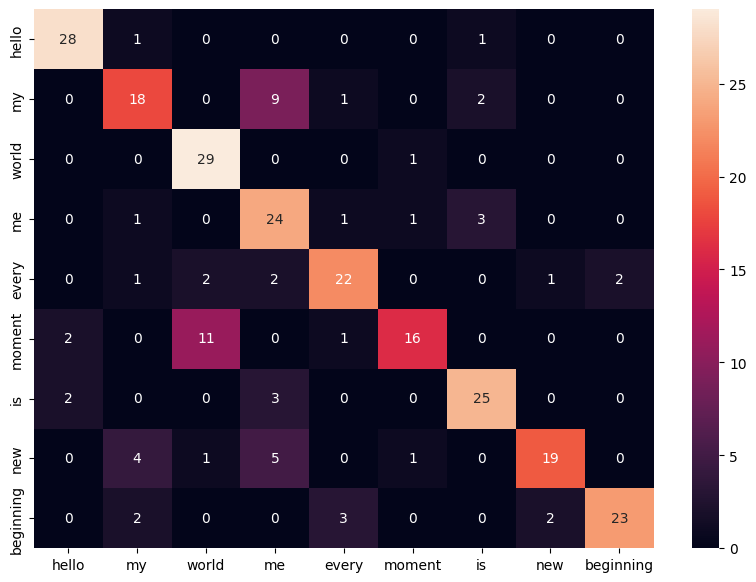

In [39]:
df_cm = pd.DataFrame(CM, index = [i for i in class_names_lst],
                  columns = [i for i in class_names_lst])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)